In [476]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
%matplotlib inline

In [477]:
#functions
def conditions(s):
    if s['favorite'] == s['Opp'] + ' ':
        return True
    elif s['favorite'] == s['Home'] + ' ':
        return False
    else:
        return 2
    
def spreadcover(s):
    if s['favorite'] == s['Home'] + ' ':
        points = s['Home_Score'] - s['Away_Score']
        if points > s['spread']:
            return True
        elif points == s['spread']:
            return 'Push'
        else:
            return False
    else:
        points = s['Away_Score'] - s['Home_Score']
        if points > s['spread']:
            return True
        elif points == s['spread']:
            return 'Push'
        else:
            return False
        
def win(s):
    if s['Home_Score'] > s['Away_Score']:
        return True
    else:
        return False
    
def win_percent(s):        
    x = s['Home_Record'].split('-')
    w = int(x[0])
    l = int(x[1])
    if w == 0:
        return 0.0
    elif w > 0 and l == 0:
        return 100
    else:
        return (w/l)
        

In [478]:
master02_10 = pd.read_csv('./data/MASTER2002_2010.csv',index_col='Unnamed: 0')
master10_20 = pd.read_csv('./data/MASTER2010_2020.csv',index_col='Unnamed: 0')

In [479]:
#The two dataframs overlap in 2010 so im going to drop 2010 from master02_10
master02_10 = master02_10[master02_10.Team_Year != 2010]

In [480]:
master = pd.concat([master02_10,master10_20])
master['HomeOrAway'] = master['HomeOrAway'].astype(str)
master = master[~master.HomeOrAway.str.contains('@')]
master.drop(['PlayersURL','VegasLink','GetBoxScoreURL','Weather','BOXSCORE', 'HomeOrAway','Links'], axis=1, inplace=True)
master = master.reset_index(drop=True)

In [481]:
master= master[master['Home_Record'].notna()]

In [482]:
master['WinPercent'] = master.apply(lambda row: win_percent(row), axis=1)

In [483]:
#breaking out lists/columns from spread and overunder
favorite = []
spread = []
for x in master['Vegas Line']:
    x = x.split('-')
    if len(x) == 1:
        favorite.append('Push')
        spread.append(0)
    else:
        favorite.append(x[0])
        spread.append(x[1])

        
OUtotal = []
OUresult = []
for x in master['Over/Under']:
    if pd.isna(x):
        OUtotal.append('NAN')
        OUresult.append('NaN')
    else:
        x = x.split('(')
        OUtotal.append(x[0])
        OUresult.append(x[1].replace(')',''))

master['spread'] = spread
master['favorite'] = favorite
master['OUtotal'] = OUtotal
master['OUresult'] = OUresult
master['HomeWin'] =  master.apply(lambda row: win(row), axis=1)
#Drop the dummy var the webscapper added
master = master[~master.Home_QB_Player.str.contains('Bobby Boucher')]
master = master[~master.Away_QB_Player.str.contains('Bobby Boucher')]
master = master[~master.H_RB2_Player.str.contains('Forrest Gump')]
master = master[~master.A_RB2_Player.str.contains('Forrest Gump')]
master = master[~master.H_WR3_Player.str.contains('Forrest Gump')]
master = master[~master.A_WR3_Player.str.contains('Forrest Gump')]



# df[~df.HomeQ.str.contains("XYZ")]

In [484]:
# x = [x for x in master.columns]
# x

In [485]:
#creating betting df and renaming columns
betting = master[['Vegas Line','spread', 'favorite','Over/Under','OUtotal','OUresult','Team_Name','Home_Score','Opp','Away_Score','Team_Year','HomeWin']]
betting = betting.rename(columns = {'Team_Name':'Home','Team_Year':'Year','Over/Under':'Over_Under'})  

In [486]:
#change column types 
betting = betting.astype({'Vegas Line': 'str','spread':'float','favorite':'category','Over_Under':'object'})
#drop rows that have NaNs in Opp column
betting= betting[betting['Opp'].notna()]


In [487]:
# Create homeunderdog and spreadcover columns with lambda
betting['Homeunderdog'] = betting.apply(lambda row: conditions(row), axis=1)
betting['Homeunderdog'] = betting['Homeunderdog'] * 1        
betting['spreadcover'] = betting.apply(lambda row: spreadcover(row), axis=1)
betting['spreadcover'] = betting['spreadcover'] * 1
betting = betting.drop(columns=['Over_Under'])
betting['HomeWin'] = betting['HomeWin'] * 1


In [488]:
betting.head()

,Vegas Line,spread,favorite,OUtotal,OUresult,Home,Home_Score,Opp,Away_Score,Year,HomeWin,Homeunderdog,spreadcover
0,San Diego Chargers -2.5,2.5,San Diego Chargers,39.0,under,Arizona Cardinals,15.0,San Diego Chargers,23.0,2002,0,1,1
1,New York Giants -3.0,3.0,New York Giants,38.5,under,Arizona Cardinals,21.0,New York Giants,7.0,2002,1,1,0
2,Arizona Cardinals -3.5,3.5,Arizona Cardinals,NAN,NaN,Arizona Cardinals,9.0,Dallas Cowboys,6.0,2002,1,0,0
3,St. Louis Rams -5.0,5.0,St. Louis Rams,43.5,under,Arizona Cardinals,14.0,St. Louis Rams,27.0,2002,0,1,1
4,Arizona Cardinals -3.0,3.0,Arizona Cardinals,37.0,under,Arizona Cardinals,6.0,Seattle Seahawks,27.0,2002,0,0,0


In [489]:
master = master.drop(master.columns[master.isna().sum()>len(master.columns)],axis = 1)
master = master.dropna(axis = 0).reset_index(drop=True)

In [490]:
betting.groupby(['Year']).groups.keys()


dict_keys([2002, 2003, 2004, 2005, 2006, 2007, 2008, 2009, 2010, 2011, 2012, 2013, 2014, 2015, 2016, 2017, 2018, 2019])

In [491]:
len(betting.groupby(['Year']).groups[2002])

267

In [492]:
betting.groupby('Year').first()

,Vegas Line,spread,favorite,OUtotal,OUresult,Home,Home_Score,Opp,Away_Score,HomeWin,Homeunderdog,spreadcover
Year,,,,,,,,,,,,
2002,San Diego Chargers -2.5,2.5,San Diego Chargers,39.0,under,Arizona Cardinals,15.0,San Diego Chargers,23.0,0,1,1
2003,Seattle Seahawks -5.0,5.0,Seattle Seahawks,44.5,under,Arizona Cardinals,0.0,Seattle Seahawks,38.0,0,1,1
2004,New England Patriots -8.0,8.0,New England Patriots,41.5,under,Arizona Cardinals,12.0,New England Patriots,23.0,0,1,1
2005,St. Louis Rams -1.0,1.0,St. Louis Rams,44.0,under,Arizona Cardinals,12.0,St. Louis Rams,17.0,0,1,1
2006,Arizona Cardinals -9.5,9.5,Arizona Cardinals,44.0,over,Arizona Cardinals,34.0,San Francisco 49ers,27.0,1,0,0
2007,Seattle Seahawks -2.5,2.5,Seattle Seahawks,42.5,over,Arizona Cardinals,23.0,Seattle Seahawks,20.0,1,1,0
2008,Arizona Cardinals -2.0,2.0,Arizona Cardinals,52.0,over,Arizona Cardinals,23.0,Pittsburgh Steelers,27.0,0,0,0
2009,Green Bay Packers -2.5,2.5,Green Bay Packers,48.0,over,Arizona Cardinals,16.0,San Francisco 49ers,20.0,0,2,1
2010,Arizona Cardinals -5.5,5.5,Arizona Cardinals,39.0,over,Arizona Cardinals,24.0,Oakland Raiders,23.0,1,0,0


In [493]:
#Get the sum of home wins per year
wins = betting.groupby(['Year','Home'])['HomeWin'].sum()
homedog = betting.groupby(['Year','Home'])[['Homeunderdog']].sum()
spreadcount = betting.groupby(['Year','Home'])[['spread']].count()
wins = wins.to_frame()

In [494]:
# wins = wins.unstack(level=0)
wins = wins.unstack(level=0)
wins.columns = wins.columns.get_level_values(1)
# level = wins.columns.get_level_values(1).astype(str)
# wins.columns = [x.replace("', '","_") for x in wins.columns]
# wins
# fg = sns.barplot(x='Year',y='HomeWin', col = 'Home', data = wins, kind = 'bar')
# fg.set_xlabes('')

In [495]:
s1 = wins[2010]
s2 = wins[2011]
s3 = wins[2012]
s4 = wins[2013]
s5 = wins[2014]
s6 = wins[2015]
s7 = wins[2016]
s8 = wins[2017]
s9 = wins[2018]
s10 = wins[2019]

wins = pd.concat([s1, s2, s3, s4, s5, s6, s7, s8, s9, s10], axis=1).reset_index()
# sns.lineplot(data=wins)
# plt.figure(figsize=(900,900))
# wins.unstack(level=0).plot(kind='bar', subplots=True)

Text(0, 0.5, 'Home Wins')

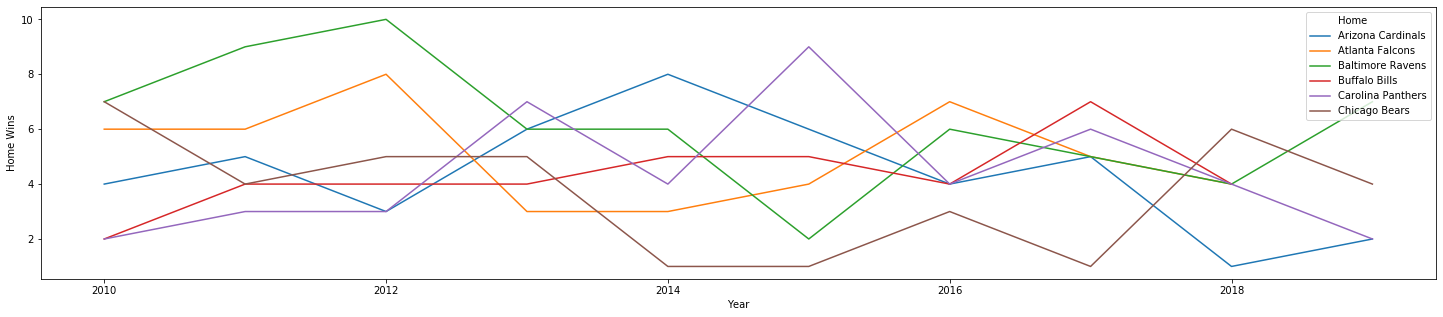

In [496]:
wins1 = wins.iloc[0:6]
wins2 = wins.iloc[6:12]
wins3 = wins.iloc[12:18]
wins4 = wins.iloc[18:25]
wins5 = wins.iloc[25:]


plt.figure(figsize=(25, 5))
sns.lineplot(x='variable', y='value', hue='Home',data=pd.melt(wins1, ['Home']))
plt.xlabel("Year")
plt.ylabel("Home Wins")

Text(0, 0.5, 'Home Wins')

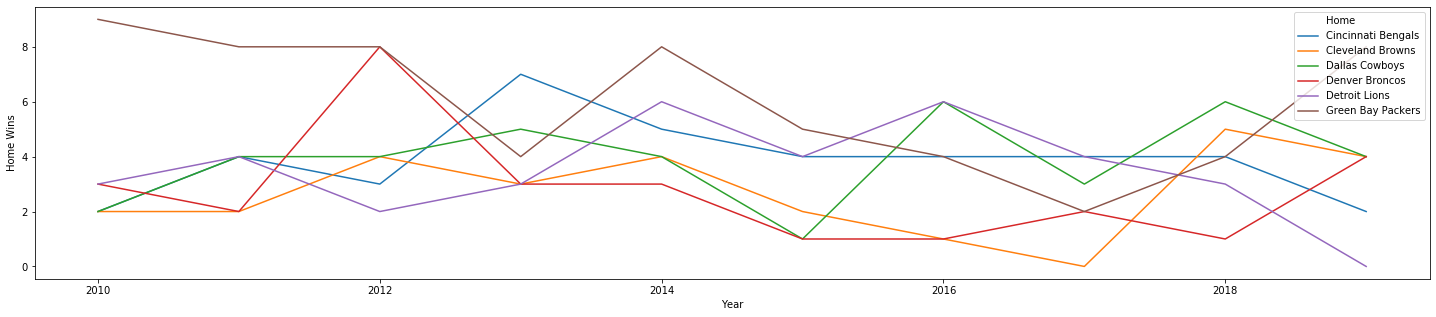

In [497]:
plt.figure(figsize=(25, 5))
sns.lineplot(x='variable', y='value', hue='Home',data=pd.melt(wins2, ['Home']))
plt.xlabel("Year")
plt.ylabel("Home Wins")

Text(0, 0.5, 'Home Wins')

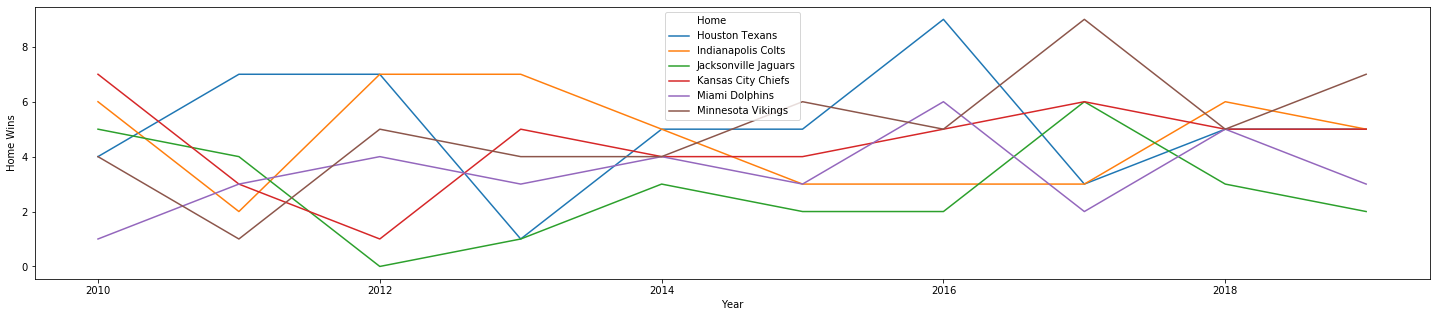

In [498]:
plt.figure(figsize=(25, 5))
sns.lineplot(x='variable', y='value', hue='Home',data=pd.melt(wins3, ['Home']))
plt.xlabel("Year")
plt.ylabel("Home Wins")

Text(0, 0.5, 'Home Wins')

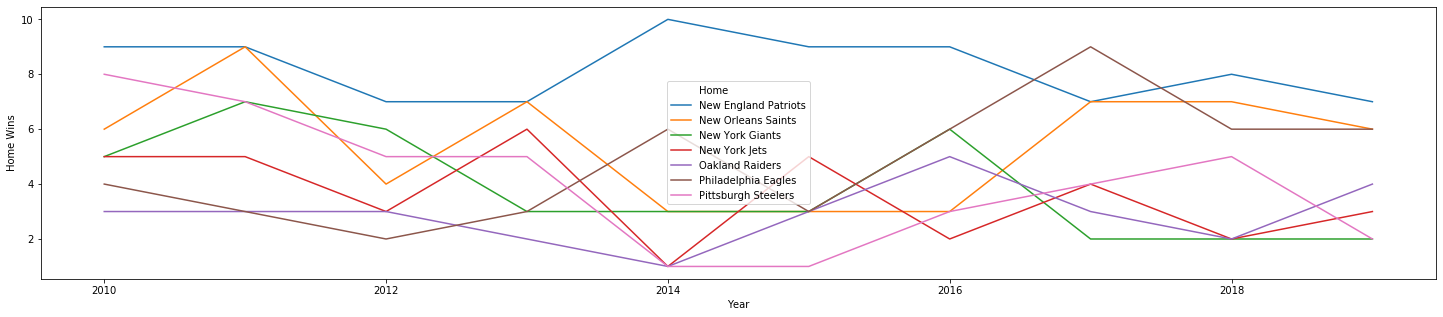

In [499]:
plt.figure(figsize=(25, 5))
sns.lineplot(x='variable', y='value', hue='Home',data=pd.melt(wins4, ['Home']))
plt.xlabel("Year")
plt.ylabel("Home Wins")

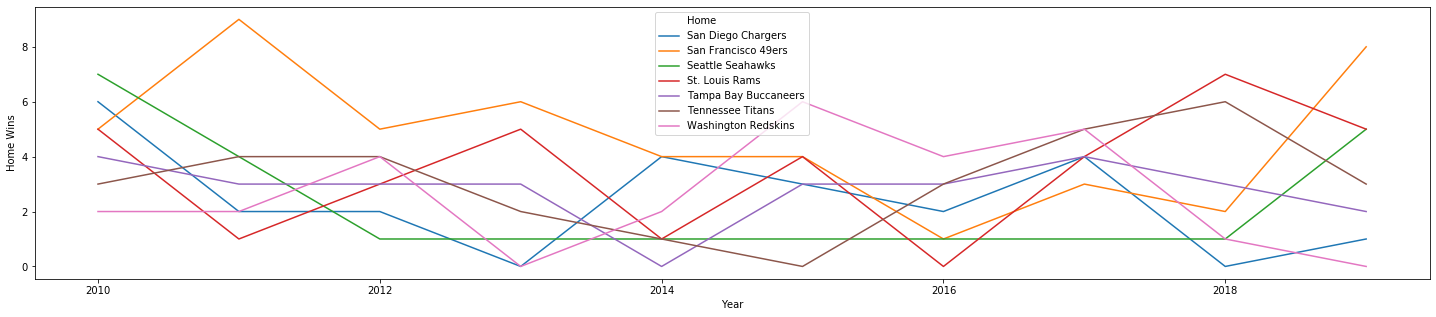

In [500]:
plt.figure(figsize=(25, 5))
sns.lineplot(x='variable', y='value', hue='Home',data=pd.melt(wins5, ['Home']))
plt.xlabel("Year")
plt.ylabel("Home Wins")
plt.legend()

Text(0.5, 1.0, 'Home Underdog Per Year distribution')

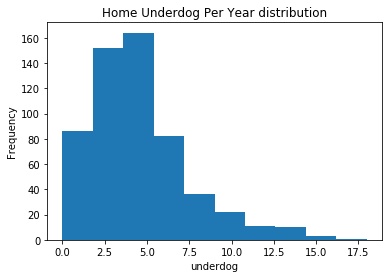

In [501]:
homedog.hist(grid=False)
plt.xlabel('underdog')
plt.ylabel("Frequency",fontsize=10)
plt.title('Home Underdog Per Year distribution')

Text(0.5, 1.0, 'spread Distribution')

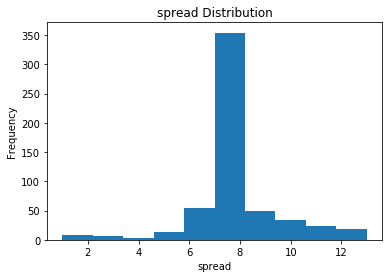

In [502]:
spreadcount.hist(grid=False)
plt.xlabel('spread')
plt.ylabel("Frequency",fontsize=10)
plt.title('spread Distribution')

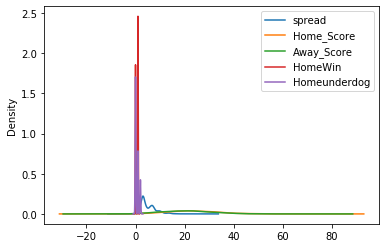

In [470]:
corrdata = betting.copy()
corrdata = corrdata.drop(columns=['Year'])
corrdata.plot(kind='density', layout=(3,3), sharex=False)

spread             AxesSubplot(0.125,0.536818;0.227941x0.343182)
Home_Score      AxesSubplot(0.398529,0.536818;0.227941x0.343182)
Away_Score      AxesSubplot(0.672059,0.536818;0.227941x0.343182)
HomeWin               AxesSubplot(0.125,0.125;0.227941x0.343182)
Homeunderdog       AxesSubplot(0.398529,0.125;0.227941x0.343182)
dtype: object

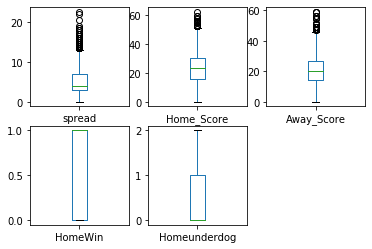

In [471]:
corrdata.plot(kind='box', subplots=True, layout=(2,3), sharex = False, sharey=False)

In [472]:
correlation = betting.corr()
names = correlation.columns

[Text(0, 0, 'spread'),
 Text(0, 0, 'Home_Score'),
 Text(0, 0, 'Away_Score'),
 Text(0, 0, 'Year'),
 Text(0, 0, 'HomeWin')]

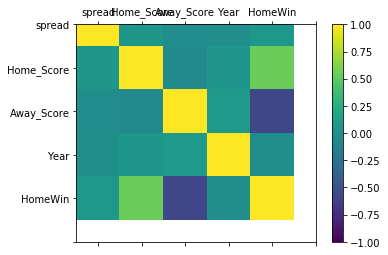

In [473]:
fig = plt.figure()
ax = fig.add_subplot(111)
cax = ax.matshow(correlation, vmin=-1, vmax=1)
fig.colorbar(cax)
ticks = np.arange(0,5.05,1)
ax.set_xticks(ticks)
ax.set_yticks(ticks)
ax.set_xticklabels(names)
ax.set_yticklabels(names)

/Users/justinmurray/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:2: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  


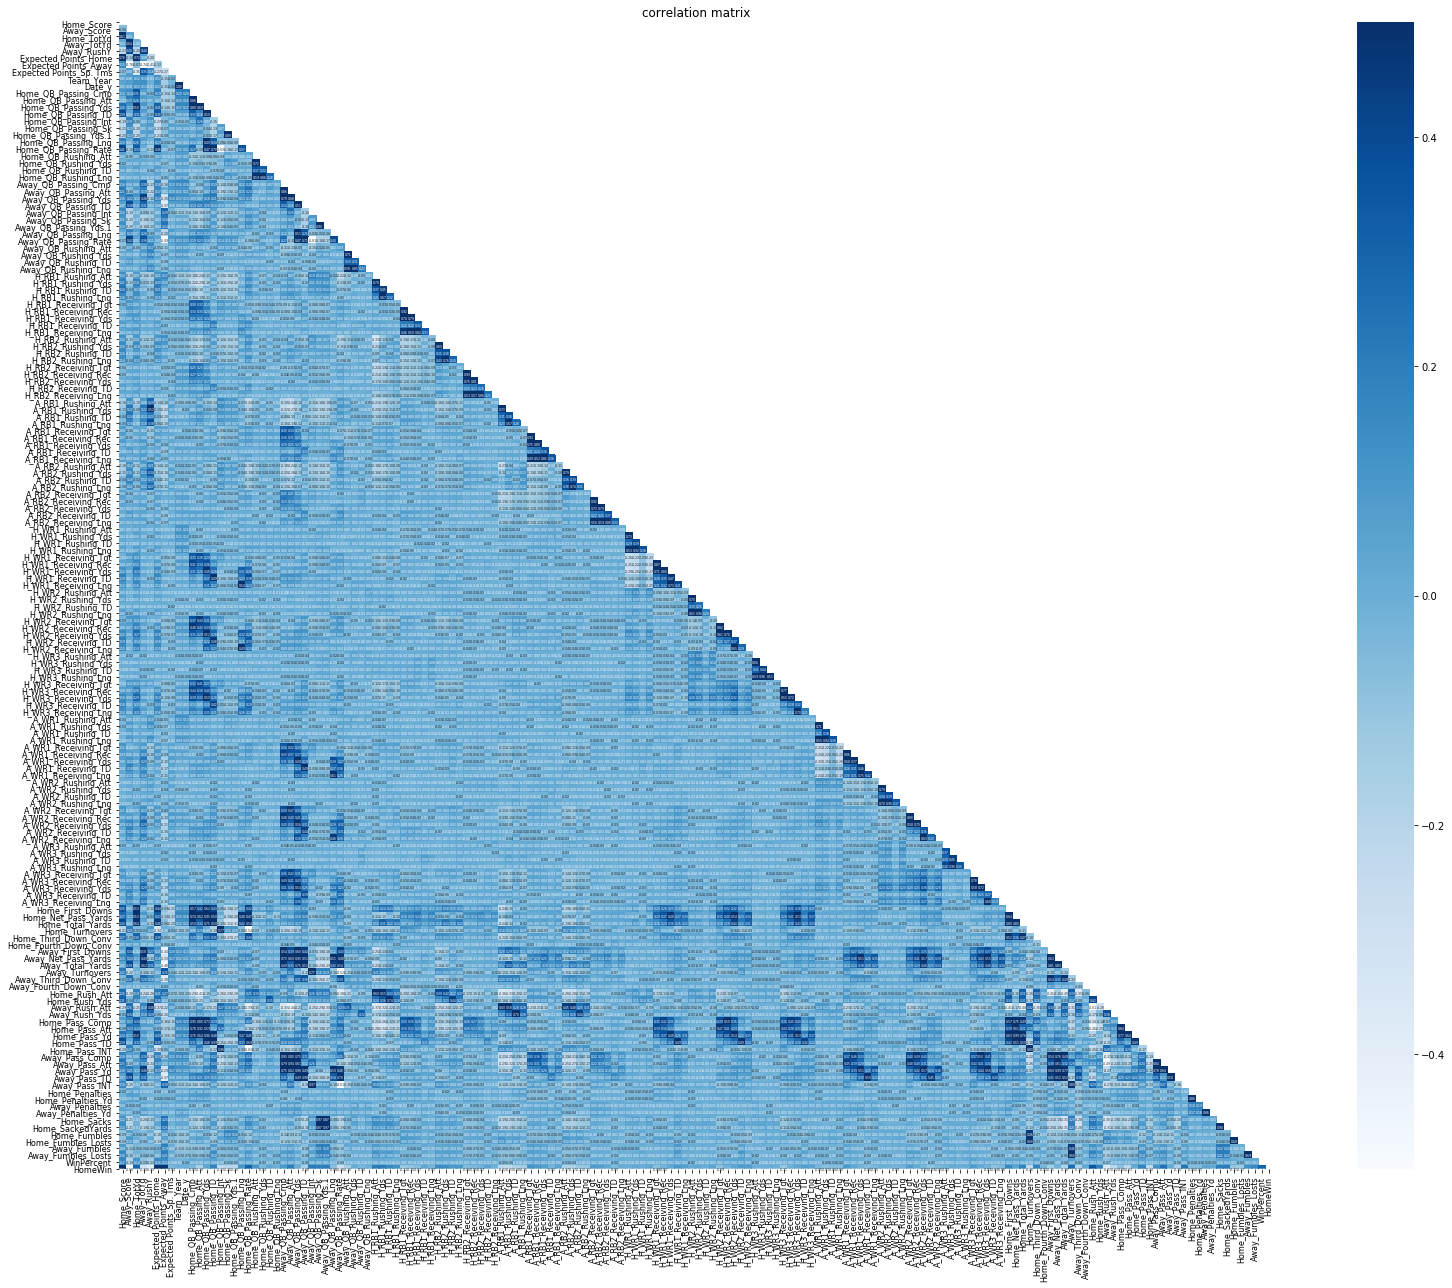

In [504]:
corr = master.iloc[:, 1:].corr()
arr_corr = corr.as_matrix()
# mask out the top triangle
arr_corr[np.triu_indices_from(arr_corr)] = np.nan

fig, ax = plt.subplots(figsize=(24, 18))

hm = sns.heatmap(arr_corr, cbar=True, vmin=-0.5, vmax=0.5,
                 fmt='.2f', annot_kws={'size': 3}, annot=True, 
                 square=True, cmap=plt.cm.Blues)

ticks = np.arange(corr.shape[0]) + 0.5
ax.set_xticks(ticks)
ax.set_xticklabels(corr.columns, rotation=90, fontsize=8)
ax.set_yticks(ticks)
ax.set_yticklabels(corr.index, rotation=360, fontsize=8)

ax.set_title('correlation matrix')
plt.tight_layout()
plt.savefig("large_corr_matrix.png", dpi=300)


In [503]:
master.to_csv(r'./data/MASTERCLEAN.csv', encoding='utf-8', header='true')
betting.to_csv(r'./data/BETTING.csv', encoding='utf-8', header='true')

In [376]:
#one-hot encode the data using pd get_dummies
from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import train_test_split
features = pd.get_dummies(master)
features

,Home_Score,Away_Score,Home_TotYd,Away_TotYd,Away_RushY,Expected Points_Home,Expected Points_Away,Expected Points_Sp. Tms,Team_Year,Date_y,...,OUtotal_57.0,OUtotal_58.0,OUtotal_58.5,OUtotal_59.5,OUtotal_60.0,OUtotal_NAN,OUresult_NaN,OUresult_over,OUresult_push,OUresult_under
0,15.0,23.0,297.0,289.0,125.0,-8.41,2.10,0.09,2002,200209220,...,0,0,0,0,0,0,0,0,0,1
1,21.0,7.0,263.0,263.0,67.0,-0.97,21.35,-3.23,2002,200209290,...,0,0,0,0,0,0,0,0,0,1
2,9.0,6.0,380.0,342.0,148.0,-6.06,9.02,-0.95,2002,200210200,...,0,0,0,0,0,1,1,0,0,0
3,14.0,27.0,235.0,415.0,192.0,-14.26,-6.93,6.58,2002,200211030,...,0,0,0,0,0,0,0,0,0,1
4,6.0,27.0,337.0,406.0,151.0,-4.81,-17.71,-1.34,2002,200211100,...,0,0,0,0,0,0,0,0,0,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
4326,15.0,31.0,356.0,298.0,90.0,-9.86,-9.23,3.52,2019,201909230,...,0,0,0,0,0,0,0,1,0,0
4327,7.0,33.0,223.0,442.0,130.0,-20.78,-9.23,6.54,2019,201910060,...,0,0,0,0,0,0,0,0,0,1
4328,0.0,9.0,154.0,283.0,137.0,-14.12,1.99,0.61,2019,201910200,...,0,0,0,0,0,0,0,0,0,1
4329,17.0,34.0,225.0,400.0,115.0,-16.32,-10.08,9.20,2019,201911170,...,0,0,0,0,0,0,0,1,0,0


In [375]:
features['HomeWin']

IndexError: only integers, slices (`:`), ellipsis (`...`), numpy.newaxis (`None`) and integer or boolean arrays are valid indices

In [351]:
# predict labels after we turn them in to an np.array
labels= np.array(features['HomeWin'])
# remove the labels
features = features.drop('HomeWin', axis = 1)
#Save feature name for later 
feature_list = list(features.columns)
#convert to numpy array
features = np.array(features)

# Training and Testing sets

In [357]:
from sklearn.model_selection import train_test_split
x = 


In [361]:
#make tree and train
tree = DecisionTreeClassifier(random_state = 23)
tree.fit(train_features, train_labels)

DecisionTreeClassifier(class_weight=None, criterion='gini', max_depth=None,
                       max_features=None, max_leaf_nodes=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=1, min_samples_split=2,
                       min_weight_fraction_leaf=0.0, presort=False,
                       random_state=23, splitter='best')

In [363]:
print(f'Model Accuracy: {tree.score(train_features, train_labels)}')

Model Accuracy: 1.0


AttributeError: 'list' object has no attribute 'head'

In [352]:
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestRegressor

In [353]:
# split into train and test sets (70-30)
train_features, test_features, train_labels, test_labels = train_test_split(features, labels, test_size = .3, random_state = 55)

In [354]:
rf = RandomForestRegressor(n_estimators = 1000, random_state = 55)
rf.fit(train_features, train_labels)

RandomForestRegressor(bootstrap=True, criterion='mse', max_depth=None,
                      max_features='auto', max_leaf_nodes=None,
                      min_impurity_decrease=0.0, min_impurity_split=None,
                      min_samples_leaf=1, min_samples_split=2,
                      min_weight_fraction_leaf=0.0, n_estimators=1000,
                      n_jobs=None, oob_score=False, random_state=55, verbose=0,
                      warm_start=False)

In [355]:
#predictions on test data
predictions = rf.predict(test_features)

#calc errors
errors = abs(predictions - test_labels)

#mean absolute error
print('Mean Absolute Error:', round(np.mean(errors), 2))

Mean Absolute Error: 0.0


In [356]:
mape = 100 * (errors / test_labels)
accuracy = 100 - np.mean(mape)
print('Accuracy:', round(accuracy, 2), '%.')

Accuracy: nan %.


/Users/justinmurray/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:1: RuntimeWarning: divide by zero encountered in true_divide
  """Entry point for launching an IPython kernel.
/Users/justinmurray/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:1: RuntimeWarning: invalid value encountered in true_divide
  """Entry point for launching an IPython kernel.


In [ ]:
groupby.set_index('Year')[['Opp']].rename(columns={'Opp':name})

In [ ]:
#Drop bobby boucher and forest gump
homeQBTD = pd.pivot_table(master, 'Home_QB_Passing_TD', 'Home_QB_Player', 'Team_Name').sum()
homeRBTD = pd.pivot_table(master, 'H_RB1_Rushing_TD', 'H_RB1_Player', 'Team_Name').sum()
homeWRTD = pd.pivot_table(master, 'H_WR1_Receiving_TD', 'H_WR1_Player', 'Team_Name').sum()
awayQBTD = pd.pivot_table(master, 'Away_QB_Passing_TD', 'Away_QB_Player', 'Team_Name').sum()
awayRBTD = pd.pivot_table(master, 'A_RB1_Rushing_TD', 'A_RB1_Player', 'Team_Name').sum()
awayWRTD = pd.pivot_table(master, 'A_WR1_Receiving_TD', 'A_WR1_Player', 'Team_Name').sum()
homeRBTD = pd.pivot_table(master, 'H_RB1_Rushing_TD', 'H_RB1_Player', 'Team_Name').sum()

# awayRBTD = pd.pivot_table(master, 'A_RB1_Rushing_TD', 'Team_Name','A_RB1_Player').sum()






In [ ]:
master['W_L'].value_counts()

In [ ]:
master['WL'] = master['W_L'].replace({'W':1,'T':0,'L':-1})
master['HomeWin'] = master['W_L'] == 'W'
master['HomeLost'] = master['W_L'] == 'L'
master['HomeTie'] = master['W_L'] == 'T'

master['HomeWin'] = master['HomeWin']*1
master['HomeLost'] = master['HomeLost']*1
master['HomeTie'] = master['HomeTie']*1


In [ ]:

TotalWins = master.groupby('Team_Name', as_index=False).agg({"HomeWin": "sum"})
TotalLoses = master.groupby('Team_Name', as_index=False).agg({"HomeLost": "sum"})
Total = pd.merge(TotalWins, TotalLoses, left_on='Team_Name', right_on='Team_Name')
Total
Total['WinPrecent'] = (Total['HomeWin']/(Total['HomeWin']+Total['HomeLost'])) * 100


In [ ]:
betting.head()

# bettinghead.to_csv(r'./data/betting.csv', encoding='utf-8', header='true')

In [ ]:
fav = betting['favorite'].value_counts()
type(fav)

In [ ]:
invYr = invoices.groupby(['FinYear']).sum()[['Amount']]


In [ ]:
homeWRTD.hist(bins=25, grid=False, xlabelsize=10, ylabelsize=10, label='HOME')
awayWRTD.hist(bins=25, grid=False, xlabelsize=10, ylabelsize=10, label='AWAY')
plt.xlabel('WR Touchdowns')
plt.ylabel("Frequency",fontsize=10)
plt.xlim([0,75])

In [ ]:
test = homeWRTD.to_frame('columnName')
test

In [ ]:

df1 = homeWkeys
df2 = awayWRTD

f, ax = plt.subplots(1, 1)
x_col='WR TouchDowns'
y_col = 'Frequency'

ax.plot_date(df1[0], df1, color="blue", label="A", linestyle="-")
ax.plot_date(df2.date, df2, color="red", label="B", linestyle="-")


ax.legend()

plt.hist().autofmt_xdate()
plt.show()

In [ ]:
# Team Home wins by team over all years
HomeWins = master['W_L'].groupby(master['Team_Name']).describe().sort_values(by='count', ascending=False)
AwayWins = master['W_L'].groupby(master['Home_QB_Player']).describe().sort_values(by='count', ascending=False)
group = master['W_L'].groupby([master['Team_Name'],master['Team_Year']]).count()


In [ ]:
master.info()

In [ ]:
col = [x for x in master.columns]
col

In [ ]:
master = pd.read_csv('./data/MASTER2002_2010.csv',index_col='Unnamed: 0')
test = master[-1:]

In [ ]:
col = [x for x in master.columns]
ou = test['Home_Score'] + test['Away_Score']

In [ ]:
# print(test['Home_Score'],test['Away_Score'], )
print(f"Home Score {test['Home_Score']}, Away Score {test['Away_Score']} for a total of {ou} and the overunder was {test['Over/Under']}")


In [ ]:
col
dropcols = ('PlayersURL','VegasLink','GetBoxScoreURL','Weather')

In [ ]:
# 2002-2005  06-20
#madden ranking

html = get(url)
soup = Soup(html)
dfstats = pd.read_html(str(soup.find('table')[2]))[0]